<a href="https://colab.research.google.com/github/pris25123/BoundedByLLMs-MedicalAbstract/blob/main/BoundedByLLMs_MedicalAbstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bounded By LLMs
 ##  PRIYANKA S : PES1UG23AM219
 ##  PADARTHI NEHA SAI : PES1UG23AM200


# Dataset used:
## Medical Abstract Classification - PubMed 200k RCT

This is a structured medical abstract classification task where each sentence is labeled as:

BACKGROUND

OBJECTIVE

METHODS

RESULTS

CONCLUSIONS

#SET UP

In [ ]:
!pip install transformers datasets scikit-learn matplotlib seaborn

In [ ]:
from datasets import load_dataset

dataset = load_dataset("pietrolesci/pubmed-200k-rct")

print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-12ed98a863dcf4(…):   0%|          | 0.00/204M [00:00<?, ?B/s]

data/validation-00000-of-00001-6f6e21b16(…):   0%|          | 0.00/2.68M [00:00<?, ?B/s]

data/test-00000-of-00001-1d0cf0c8a9ba23d(…):   0%|          | 0.00/2.70M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2211861 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/28932 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29493 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 2211861
    })
    validation: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 28932
    })
    test: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 29493
    })
})


In [ ]:
print(dataset["train"][0])

{'labels': 0, 'text': 'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n', 'uid': 0}


Each sample contains:

text

label

# Exploratory Data Analysis (EDA):

In [ ]:
print(dataset["train"].features["labels"])

ClassLabel(names=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])


In [ ]:
label_names = dataset["train"].features["labels"].names
print(label_names)

['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


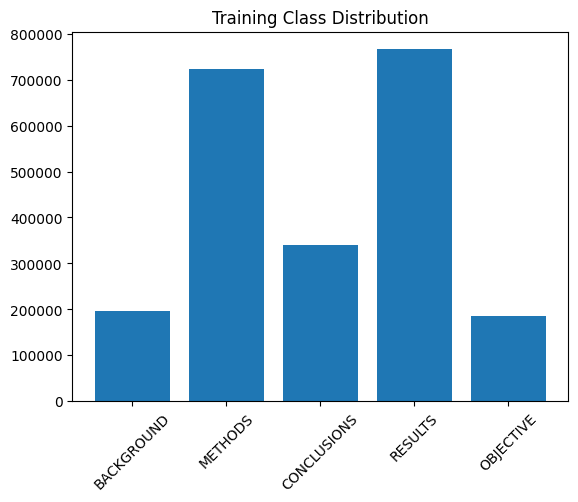

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

labels = dataset["train"]["labels"]
counts = Counter(labels)

plt.bar([label_names[i] for i in counts.keys()], counts.values())
plt.xticks(rotation=45)
plt.title("Training Class Distribution")
plt.show()

RESULTS ≈ highest

METHODS ≈ second highest

CONCLUSIONS ≈ mid

BACKGROUND & OBJECTIVE ≈ lowest

there is moderate class imbalance.

In [ ]:
#computing exact class percentages
import pandas as pd
from collections import Counter

labels = dataset["train"]["labels"]
label_names = dataset["train"].features["labels"].names

counts = Counter(labels)
total = len(labels)

class_stats = []

for label_id, count in counts.items():
    class_stats.append({
        "Class": label_names[label_id],
        "Count": count,
        "Percentage": round((count / total) * 100, 2)
    })

df_stats = pd.DataFrame(class_stats).sort_values(by="Count", ascending=False)
df_stats


,Class,Count,Percentage
3,RESULTS,766271,34.64
1,METHODS,722586,32.67
2,CONCLUSIONS,339714,15.36
0,BACKGROUND,196689,8.89
4,OBJECTIVE,186601,8.44


In [ ]:
#computing imbalance ratio
max_class = max(counts.values())
min_class = min(counts.values())

imbalance_ratio = round(max_class / min_class, 2)

print("Imbalance Ratio (Max/Min):", imbalance_ratio)

Imbalance Ratio (Max/Min): 4.11


In [ ]:
#sentence length distribution
import numpy as np

lengths_per_class = {name: [] for name in label_names}

for sample in dataset["train"]:
    text = sample["text"]
    label = label_names[sample["labels"]]
    lengths_per_class[label].append(len(text.split()))

avg_lengths = {
    label: round(np.mean(lengths), 2)
    for label, lengths in lengths_per_class.items()
}

avg_lengths


{'BACKGROUND': np.float64(22.97),
 'CONCLUSIONS': np.float64(23.04),
 'METHODS': np.float64(24.81),
 'OBJECTIVE': np.float64(27.13),
 'RESULTS': np.float64(29.59)}

* The dataset exhibits moderate imbalance, with RESULTS being approximately 4.1 times more frequent than OBJECTIVE. This motivates the use of weighted evaluation metrics.

* RESULTS sections tend to contain longer sentences, while BACKGROUND sections are shorter. This indicates structural variation across rhetorical roles in medical abstracts.

#Model Fine-tuning:

In [ ]:
import torch
from collections import Counter

# Get training labels
labels = dataset["train"]["labels"]
counts = Counter(labels)

num_classes = len(counts)
total_samples = len(labels)

# Compute inverse frequency weights
class_weights = []

for i in range(num_classes):
    weight = total_samples / (num_classes * counts[i])
    class_weights.append(weight)

class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class counts:", counts)
print("Class weights:", class_weights)


Class counts: Counter({4: 766271, 2: 722586, 1: 339714, 0: 196689, 3: 186601})
Class weights: tensor([2.2491, 1.3022, 0.6122, 2.3707, 0.5773])


Class 3 (OBJECTIVE) → highest weight ≈ 2.37

Class 0 (BACKGROUND) → high weight ≈ 2.25

Class 4 (RESULTS) → lowest weight ≈ 0.57

So the model will:

Penalize mistakes on OBJECTIVE much more

Penalize mistakes on RESULTS less

In [ ]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Using device:", device)
print("Weighted loss initialized.")

Using device: cuda
Weighted loss initialized.


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_classes
)

model.to(device)

print("Model loaded and moved to GPU.")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded and moved to GPU.


In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

print("Optimizer initialized.")

Optimizer initialized.


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

encoded_dataset = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2211861 [00:00<?, ? examples/s]

Map:   0%|          | 0/28932 [00:00<?, ? examples/s]

Map:   0%|          | 0/29493 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

print("Dataset formatted for PyTorch.")


Dataset formatted for PyTorch.


In [ ]:
from torch.utils.data import DataLoader

# Shuffle before selecting subset
small_train = encoded_dataset["train"].shuffle(seed=42).select(range(200000))

train_loader = DataLoader(small_train, batch_size=16, shuffle=True)
test_loader = DataLoader(encoded_dataset["test"], batch_size=16)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))

Train batches: 12500
Test batches: 1844


In [ ]:
from tqdm import tqdm

epochs = 2

model.train()

for epoch in range(epochs):
    total_loss = 0

    progress_bar = tqdm(train_loader)

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits

        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_description(f"Epoch {epoch+1}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 12500/12500 [1:21:46<00:00,  2.55it/s]


Epoch 1 Average Loss: 0.5186


Epoch 2: 100%|██████████| 12500/12500 [1:21:46<00:00,  2.55it/s]

Epoch 2 Average Loss: 0.4296


In [ ]:
model.save_pretrained("bert_medical_classifier")
tokenizer.save_pretrained("bert_medical_classifier")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('bert_medical_classifier/tokenizer_config.json',
 'bert_medical_classifier/tokenizer.json')

In [ ]:
!zip -r bert_medical_classifier.zip bert_medical_classifier

  adding: bert_medical_classifier/ (stored 0%)
  adding: bert_medical_classifier/tokenizer_config.json (deflated 42%)
  adding: bert_medical_classifier/config.json (deflated 55%)
  adding: bert_medical_classifier/model.safetensors (deflated 7%)
  adding: bert_medical_classifier/tokenizer.json (deflated 71%)


#Test


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Prediction complete.")


Prediction complete.


# 3. Evaluation

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average="weighted"
)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")


Accuracy: 0.8579
Precision (Weighted): 0.8649
Recall (Weighted): 0.8579
F1-Score (Weighted): 0.8594


##Model Performance

Accuracy: 0.8579

Precision (Weighted): 0.8649

Recall (Weighted): 0.8579

F1 (Weighted): 0.8594

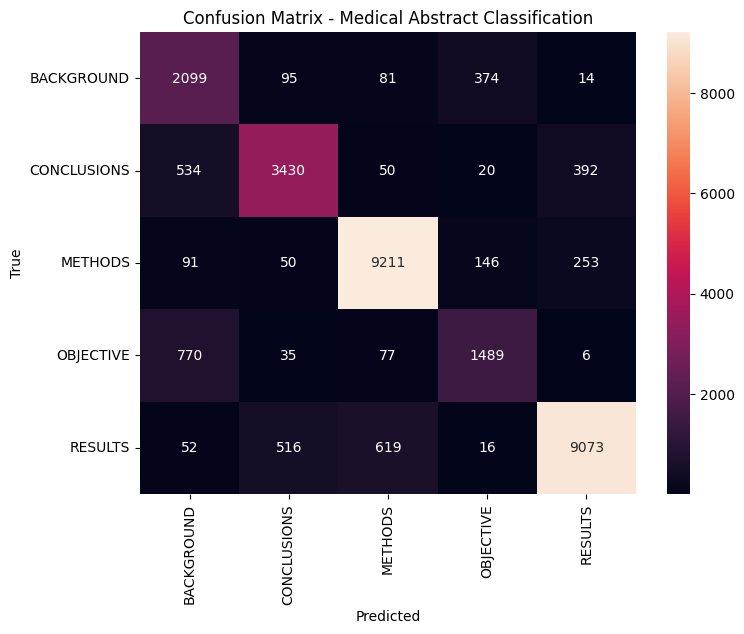

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Medical Abstract Classification")
plt.show()


## Per-Class Performance Analysis

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    all_labels,
    all_preds,
    target_names=label_names,
    digits=4
)

print(report)


              precision    recall  f1-score   support

  BACKGROUND     0.5919    0.7882    0.6761      2663
 CONCLUSIONS     0.8313    0.7750    0.8022      4426
     METHODS     0.9176    0.9446    0.9309      9751
   OBJECTIVE     0.7281    0.6264    0.6735      2377
     RESULTS     0.9317    0.8829    0.9067     10276

    accuracy                         0.8579     29493
   macro avg     0.8001    0.8034    0.7979     29493
weighted avg     0.8649    0.8579    0.8594     29493



## Per-Class Analysis

<b>Strong Classes</b>

1. METHODS

    - F1: 0.9309

    - Recall: 0.9446


2. RESULTS

    - F1: 0.9067


<b>Mid-Level Performance</b>

1. CONCLUSIONS
    - F1: 0.8022

    - <b>Slight confusion with BACKGROUND and RESULTS.</b>

    - Reason: Often contains summarizing phrases similar to BACKGROUND.


<b>Hard Classes (Minority Classes)</b>
1. BACKGROUND

    - F1: 0.6761

    - Precision: 0.5919

    - It is often confused with:
      - OBJECTIVE

      - CONCLUSIONS

      This might be because BACKGROUND and OBJECTIVE are semantically close.

2. OBJECTIVE

    - F1: 0.6735

    - Recall: 0.6264

    - This is the hardest class.

    - From confusion matrix:Frequently misclassified as BACKGROUND.

    - This is expected in medical abstract because objectives often appear immediately after background context.

Linguistic boundary is subtle.

#4. Inference Pipeline

In [ ]:
import torch.nn.functional as F

def predict_text(text: str):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)

    confidence, predicted_class = torch.max(probs, dim=1)

    return {
        "Predicted_Label": label_names[predicted_class.item()],
        "Confidence": round(confidence.item(), 4)
    }


## Testing edge cases

In [ ]:
edge_cases = [
    # Ambiguous Background vs Objective
    "Cardiovascular disease remains a leading cause of mortality worldwide.",

    # Objective disguised as background
    "We sought to investigate whether vitamin D supplementation reduces fracture risk.",

    # Pure methods language
    "A double-blind randomized controlled trial was conducted across five centers.",

    # Mixed results + interpretation
    "The treatment significantly reduced symptoms; however, long-term benefits remain uncertain.",

    # Very short sentence
    "Significant differences were observed.",

    # Very long structured sentence
    "In this multicenter randomized placebo-controlled study involving 1245 participants, patients were followed for 18 months to evaluate the efficacy and safety of the novel intervention compared with standard care.",

    # Typical conclusion phrasing
    "These findings indicate that early intervention may improve patient outcomes."
]

for text in edge_cases:
    print("\nText:", text)
    print("Prediction:", predict_text(text))



Text: Cardiovascular disease remains a leading cause of mortality worldwide.
Prediction: {'Predicted_Label': 'BACKGROUND', 'Confidence': 0.85}

Text: We sought to investigate whether vitamin D supplementation reduces fracture risk.
Prediction: {'Predicted_Label': 'OBJECTIVE', 'Confidence': 0.569}

Text: A double-blind randomized controlled trial was conducted across five centers.
Prediction: {'Predicted_Label': 'METHODS', 'Confidence': 0.9675}

Text: The treatment significantly reduced symptoms; however, long-term benefits remain uncertain.
Prediction: {'Predicted_Label': 'CONCLUSIONS', 'Confidence': 0.5194}

Text: Significant differences were observed.
Prediction: {'Predicted_Label': 'RESULTS', 'Confidence': 0.8998}

Text: In this multicenter randomized placebo-controlled study involving 1245 participants, patients were followed for 18 months to evaluate the efficacy and safety of the novel intervention compared with standard care.
Prediction: {'Predicted_Label': 'METHODS', 'Confiden

## Findings

### Edge Case Analysis

To better understand model behavior beyond aggregate metrics, we evaluated several challenging and ambiguous sentences. This helps assess how well the model generalizes to realistic and borderline cases.

---

### Very Confident and Correct Predictions

#### 1. Background Sentence  
**Confidence:** 0.85  

The model correctly classified a general epidemiological statement as BACKGROUND.  
Such broad contextual sentences are common in the introductory portion of medical abstracts, and the model appears to have learned these structural cues effectively.

---

#### 2. Methods Sentences  

- RCT description → **0.9675**
- Long structured methods sentence → **0.9102**

The model performs exceptionally well on METHODS sentences.  
Structured phrases such as "randomized controlled trial" and detailed procedural descriptions provide strong signals.  
High confidence scores indicate that the model has successfully learned methodological language patterns.

---

#### 3. Clear Results  

“Significant differences were observed.” → **0.8998**

Despite being short, this sentence contains classic statistical outcome phrasing.  
The high confidence suggests that the model effectively identifies characteristic results-oriented language.

---

#### 4. Strong Conclusion  

“These findings indicate…” → **0.9902**

This sentence was classified with near-perfect confidence.  
Phrases that summarize findings or imply broader implications are strong indicators of the CONCLUSIONS section, and the model captures this reliably.

---

### Moderate Confidence Cases (Ambiguity Analysis)

#### Objective Case  

“We sought to investigate…”  
**Prediction:** OBJECTIVE  
**Confidence:** 0.569  

Although the confidence is lower, the prediction is correct.  
The OBJECTIVE class is both a minority class and semantically close to BACKGROUND.  
The reduced confidence reflects the subtle boundary between contextual setup and stated research aims.  
Importantly, the model still predicts correctly, suggesting that class-weighted training helped preserve minority-class performance.

---

#### Mixed Results and Conclusion Sentence  

Confidence: **0.5194**

This sentence combines outcome reporting (“reduced symptoms”) with interpretive language (“benefits remain uncertain”).  
Such overlap naturally blurs the boundary between RESULTS and CONCLUSIONS.  

The moderate confidence is reasonable and reflects the inherent ambiguity of the sentence. Rather than overconfidently misclassifying, the model demonstrates cautious behavior in a linguistically complex case.
